In [1]:
!pip install transforms3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Project 3: Visual-Inertial SLAM

## Provided Functions pr3_u

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import mat2euler

def load_data(file_name):
    '''
    function to read visual features, IMU measurements, and calibration parameters
    Input:
        file_name: the input data file. Should look like "XX.npz"
    Output:
        t: time stamp
            with shape 1*t
        features: visual feature point coordinates in stereo images, 
            with shape 4*n*t, where n is number of features
        linear_velocity: velocity measurements in IMU frame
            with shape 3*t
        angular_velocity: angular velocity measurements in IMU frame
            with shape 3*t
        K: (left)camera intrinsic matrix
            with shape 3*3
        b: stereo camera baseline
            with shape 1
        imu_T_cam: extrinsic transformation from (left) camera to imu frame, in SE(3).
            with shape 4*4
    '''
    with np.load(file_name) as data:
    
        t = data["time_stamps"] # time_stamps
        features = data["features"] # 4 x num_features : pixel coordinates of the visual features
        linear_velocity = data["linear_velocity"] # linear velocity in body-frame coordinates
        angular_velocity = data["angular_velocity"] # angular velocity in body-frame coordinates
        K = data["K"] # intrinsic calibration matrix
        b = data["b"] # baseline
        imu_T_cam = data["imu_T_cam"] # transformation from left camera frame to imu frame 
    
    return t,features,linear_velocity,angular_velocity,K,b,imu_T_cam


def visualize_trajectory_2d(pose,path_name="Unknown",show_ori=False):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()
    # plt.show(block=True)

    return fig, ax




def projection(ph):
  '''
  ph = n x 4 = homogeneous point coordinates
  r = n x 4 = ph/ph[...,2] = normalized z axis coordinates
  '''  
  return ph/ph[...,2,None]
  
def projectionJacobian(ph):
  '''
  ph = n x 4 = homogeneous point coordinates
  J = n x 4 x 4 = Jacobian of ph/ph[...,2]
  '''  
  J = np.zeros(ph.shape+(4,))
  iph2 = 1.0/ph[...,2]
  ph2ph2 = ph[...,2]**2
  J[...,0,0], J[...,1,1],J[...,3,3] = iph2,iph2,iph2
  J[...,0,2] = -ph[...,0]/ph2ph2
  J[...,1,2] = -ph[...,1]/ph2ph2
  J[...,3,2] = -ph[...,3]/ph2ph2
  return J


def inversePose(T):
  '''
  @Input:
    T = n x 4 x 4 = n elements of SE(3)
  @Output:
    iT = n x 4 x 4 = inverse of T
  '''
  iT = np.empty_like(T)
  iT[...,0,0], iT[...,0,1], iT[...,0,2] = T[...,0,0], T[...,1,0], T[...,2,0] 
  iT[...,1,0], iT[...,1,1], iT[...,1,2] = T[...,0,1], T[...,1,1], T[...,2,1] 
  iT[...,2,0], iT[...,2,1], iT[...,2,2] = T[...,0,2], T[...,1,2], T[...,2,2]
  iT[...,:3,3] = -np.squeeze(iT[...,:3,:3] @ T[...,:3,3,None])
  iT[...,3,:] = T[...,3,:]
  return iT


def axangle2skew(a):
  '''
  converts an n x 3 axis-angle to an n x 3 x 3 skew symmetric matrix 
  '''
  S = np.empty(a.shape[:-1]+(3,3))
  S[...,0,0].fill(0)
  S[...,0,1] =-a[...,2]
  S[...,0,2] = a[...,1]
  S[...,1,0] = a[...,2]
  S[...,1,1].fill(0)
  S[...,1,2] =-a[...,0]
  S[...,2,0] =-a[...,1]
  S[...,2,1] = a[...,0]
  S[...,2,2].fill(0)
  return S

def axangle2twist(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    T = n x 4 x 4 = n elements of se(3)
  '''
  T = np.zeros(x.shape[:-1]+(4,4))
  T[...,0,1] =-x[...,5]
  T[...,0,2] = x[...,4]
  T[...,0,3] = x[...,0]
  T[...,1,0] = x[...,5]
  T[...,1,2] =-x[...,3]
  T[...,1,3] = x[...,1]
  T[...,2,0] =-x[...,4]
  T[...,2,1] = x[...,3]
  T[...,2,3] = x[...,2]
  return T

def twist2axangle(T):
  '''
  converts an n x 4 x 4 twist (se3) matrix to an n x 6 axis-angle 
  '''
  return T[...,[0,1,2,2,0,1],[3,3,3,1,2,0]]

def axangle2adtwist(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    A = n x 6 x 6 = n elements of ad(se(3))
  '''
  A = np.zeros(x.shape+(6,))
  A[...,0,1] =-x[...,5]
  A[...,0,2] = x[...,4]
  A[...,0,4] =-x[...,2]
  A[...,0,5] = x[...,1]
  
  A[...,1,0] = x[...,5]
  A[...,1,2] =-x[...,3]
  A[...,1,3] = x[...,2]
  A[...,1,5] =-x[...,0]
  
  A[...,2,0] =-x[...,4]
  A[...,2,1] = x[...,3]
  A[...,2,3] =-x[...,1]
  A[...,2,4] = x[...,0]
  
  A[...,3,4] =-x[...,5] 
  A[...,3,5] = x[...,4] 
  A[...,4,3] = x[...,5]
  A[...,4,5] =-x[...,3]   
  A[...,5,3] =-x[...,4]
  A[...,5,4] = x[...,3]
  return A

def twist2pose(T):
  '''
  converts an n x 4 x 4 twist (se3) matrix to an n x 4 x 4 pose (SE3) matrix 
  '''
  rotang = np.sqrt(np.sum(T[...,[2,0,1],[1,2,0]]**2,axis=-1)[...,None,None]) # n x 1
  Tn = np.nan_to_num(T / rotang)
  Tn2 = Tn@Tn
  Tn3 = Tn@Tn2
  eye = np.zeros_like(T)
  eye[...,[0,1,2,3],[0,1,2,3]] = 1.0
  return eye + T + (1.0 - np.cos(rotang))*Tn2 + (rotang - np.sin(rotang))*Tn3
  
def axangle2pose(x):
  '''
  @Input:
    x = n x 6 = n elements of position and axis-angle
  @Output:
    T = n x 4 x 4 = n elements of SE(3)
  '''
  return twist2pose(axangle2twist(x))


def pose2adpose(T):
  '''
  converts an n x 4 x 4 pose (SE3) matrix to an n x 6 x 6 adjoint pose (ad(SE3)) matrix 
  '''
  calT = np.empty(T.shape[:-2]+(6,6))
  calT[...,:3,:3] = T[...,:3,:3]
  calT[...,:3,3:] = axangle2skew(T[...,:3,3]) @ T[...,:3,:3]
  calT[...,3:,:3] = np.zeros(T.shape[:-2]+(3,3))
  calT[...,3:,3:] = T[...,:3,:3]
  return calT


## Imports and Load Data

In [15]:
import numpy as np
from tqdm import tqdm
# from pr3_utils import *
import transforms3d
from scipy import linalg

# base_path = '/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR3/data/'
base_path = './'

# Load the measurements
filename = base_path + "/data/10.npz"
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)
correction_R = transforms3d.euler.euler2mat(np.pi, 0, 0)
correction_T = np.zeros([4, 4])
correction_T[:3, :3] = correction_R
correction_T[-1, -1] = 1
imu_T_cam = np.dot(correction_T, imu_T_cam)
downsample_features = True

In [16]:
features = features.round().astype(int)
if downsample_features:
  features = features[:, ::50]
  downsample_features = False
hidden_features = np.ones([4, 1])*-1
empty_features = np.zeros([4, 1])

In [17]:
Ks = np.vstack([K[:-1], K[:-1]])
Ks = np.hstack([Ks, np.zeros([4, 1])])
Ks[2, -1] = -K[0, 0]*b
print(Ks)

[[ 552.554261     0.         682.049453     0.       ]
 [   0.         552.554261   238.769549     0.       ]
 [ 552.554261     0.         682.049453  -331.5325566]
 [   0.         552.554261   238.769549     0.       ]]


## Utils Functions

In [18]:
# noise_for_d = 0.0001
def pixel_to_world(features, K, b, imu_T_cam, T):
  ul, vl, d = features[0], features[1], (features[0]-features[2])
  fsu, cu, fsv, cv = K[0, 0], K[0, 2], K[1, 1], K[1, 2]
  x = b*(ul-cu)/d
  y = fsu*b*( vl-cv)/(d*fsv)
  z = fsu*b/d
  coords = np.vstack([x, y, z, np.ones([1, z.shape[0]])])
  return T.dot(imu_T_cam.dot(coords))

def predict_z(imu_T_cam, coords, Ks, T):
  return Ks.dot(projection(np.linalg.inv(imu_T_cam).dot(np.linalg.inv(T).dot(coords)).T).T)

## Dead Reckoning

 19%|█▉        | 588/3025 [00:00<00:00, 5879.82it/s]C:\Users\unays\AppData\Local\Temp\ipykernel_11700\3507519430.py:5: RuntimeWarning: divide by zero encountered in true_divide
  x = b*(ul-cu)/d
C:\Users\unays\AppData\Local\Temp\ipykernel_11700\3507519430.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = fsu*b*( vl-cv)/(d*fsv)
C:\Users\unays\AppData\Local\Temp\ipykernel_11700\3507519430.py:7: RuntimeWarning: divide by zero encountered in true_divide
  z = fsu*b/d
100%|██████████| 3025/3025 [00:00<00:00, 6938.06it/s]


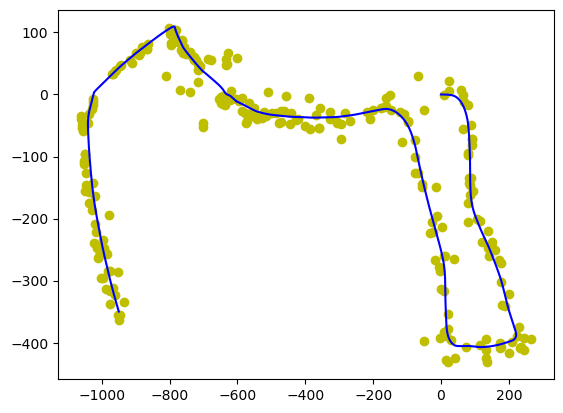

In [19]:
# (a) IMU Localization via EKF Prediction
twist_matrix = np.zeros([angular_velocity.shape[1], 4, 4])
twist_matrix[..., :3, :3] = axangle2skew(angular_velocity.T)
twist_matrix[..., :-1, -1] = linear_velocity.T

T = [np.eye(4)]
mu = np.zeros(features.shape[:-1])
for i in tqdm(range(twist_matrix.shape[0]-1)):
	T.append(np.dot(T[-1], linalg.expm((t[0, i+1]-t[0, i]) * twist_matrix[i])))
	visible_features_positions = np.where(np.all(features[..., i] != hidden_features, 0))[0]
	visible_features = features[:, visible_features_positions, i]
	mu[:, visible_features_positions] = pixel_to_world(visible_features, K, b, imu_T_cam, T[i])
 
T = np.array(T)
T = np.transpose(T, [1, 2, 0])

plt.plot(T[0, -1], T[1, -1], c='b')
plt.scatter(mu[0], mu[1], c='y')

## Landmark Mapping with EKF

In [20]:
P = np.hstack([np.eye(3), np.zeros([3, 1])])
V = 3
sigma = np.eye(3*features.shape[1]) # 3M x 3M
mu = np.zeros([4, features.shape[1]])
prev_features = np.where(np.all(features[..., 0]!=hidden_features, 0))[0]
mu[:, prev_features] = pixel_to_world(features[:, prev_features, 0], K, b, imu_T_cam, T[..., 0])

for timestamp in tqdm(range(1, t.shape[1])):
  visible_features_positions = np.where(np.all(features[..., timestamp]!=hidden_features, 0))[0]
  seen_features_positions = np.where(np.all(mu!=empty_features, 0))[0]
  seen_features_again_positions = np.intersect1d(visible_features_positions, seen_features_positions)
  new_features_positions = np.setdiff1d(visible_features_positions, seen_features_positions)

  seen_features_again = features[:, seen_features_again_positions, timestamp]
  seen_features_again_flatten_shape = seen_features_again.flatten('F').shape[0] # 4Nt
  seen_features_again_positions_shape = seen_features_again_positions.shape[0] # Nt
  new_features = features[:, new_features_positions, timestamp]
  
  mu[:, new_features_positions] = pixel_to_world(new_features, K, b, imu_T_cam, T[..., timestamp])

  z_tilda = predict_z(imu_T_cam, mu[:, seen_features_again_positions], Ks, T[..., timestamp])

  H = np.zeros([seen_features_again_flatten_shape, 3*seen_features_again_positions_shape])  # 4Nt x 3M
  h1 = projectionJacobian(np.linalg.inv(imu_T_cam).dot(np.linalg.inv(T[..., timestamp]).dot(mu[:, seen_features_again_positions])).T)
  h2 = np.linalg.inv(imu_T_cam).dot(np.linalg.inv(T[..., timestamp]).dot(P.T))
  h = np.einsum('aij,jk->aik',h1,h2) 
  h = np.einsum('ij,ajl->ail',Ks,h)

  for i in range(seen_features_again_positions.shape[0]):
    H[i*4: i*4+4, i*3:i*3+3] = h[i, :, :]

  IV = V*np.eye(seen_features_again_flatten_shape)
  new_sigma = np.zeros([3*seen_features_again_positions_shape, 3*seen_features_again_positions_shape]) #  3Nt x 3Nt

  for i in range(seen_features_again_positions_shape):
    new_sigma[3*i:3*i+3, 3*i:3*i+3] = sigma[3*seen_features_again_positions[i]:3*seen_features_again_positions[i]+3, 3*seen_features_again_positions[i]:3*seen_features_again_positions[i]+3]

  k_1 = new_sigma.dot(H.T)
  k_2 = H.dot(new_sigma.dot(H.T)) + IV
  kalman_gain = k_1.dot(np.linalg.inv(k_2))

  del_z = seen_features_again - z_tilda
  del_z = del_z.flatten('F') #  4Nt
  K_del_z = kalman_gain.dot(del_z)
  new_mu = mu[:3].flatten('F') #  3M

  for i in range(seen_features_again_positions.shape[0]):
    new_mu[3*seen_features_again_positions[i]:3*seen_features_again_positions[i]+3] = \
    new_mu[3*seen_features_again_positions[i]:3*seen_features_again_positions[i]+3] + K_del_z[3*i:3*i+3]

  new_sigma = (np.eye(3*seen_features_again_positions_shape) - kalman_gain.dot(H)).dot(new_sigma)

  for i in range(seen_features_again_positions_shape):
    sigma[3*seen_features_again_positions[i]:3*seen_features_again_positions[i]+3, 3*seen_features_again_positions[i]:3*seen_features_again_positions[i]+3] = \
    new_sigma[3*i:3*i+3, 3*i:3*i+3]
  
  mu = np.vstack([new_mu.reshape([3, features.shape[1]], order='F'), np.ones([1, features.shape[1]])])

100%|██████████| 3025/3025 [00:01<00:00, 2774.38it/s]


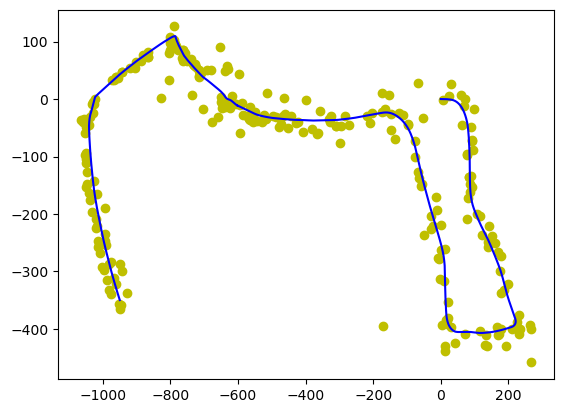

In [21]:
plt.plot(T[0, -1], T[1, -1], c='b')
plt.scatter(mu[0], mu[1], c='y')

## Visual SLAM

In [22]:
def dot(pos):
  Nt = pos.shape[1]
  z = np.zeros([4, 6, Nt])
  skew = -axangle2skew(pos[:3,:].T)
  for i in range(Nt):
    z[:3, :3, i] = np.eye(3)
    z[:3, 3:6, i] = skew[i]
  return z

In [43]:
P = np.hstack([np.eye(3), np.zeros([3, 1])])
V = 4
world_coordinates = np.zeros([4, features.shape[1]]) # 4 x M
prev_features = np.where(np.all(features[..., 0]!=hidden_features, 0))[0]
world_coordinates[:, prev_features] = pixel_to_world(features[:, prev_features, 0], 
                                                     K, b, imu_T_cam, T[..., 0])

# Trajectory for SLAM, t-th value updated at t-th timestamp
SLAM_T = np.zeros([4, 4, t.shape[1]])
SLAM_T[..., 0] = np.eye(4)

SLAM_sigma_T = np.zeros([6, 6, t.shape[1]])
SLAM_sigma = np.eye(3*features.shape[1] + 6)
# SLAM_sigma = np.random.random([3*features.shape[1] + 6, 3*features.shape[1] + 6])
SLAM_robot_init = np.diag([0.001, 0.001, 0.001, 0.00001, 0.00001, 0.00001])
SLAM_sigma[3*features.shape[1]:, 3*features.shape[1]:] = SLAM_robot_init
W = np.diag([0.1,0.01,0.01,0.00001,0.00001,0.0001])
M = features.shape[1]

In [49]:
twist = np.vstack([linear_velocity, angular_velocity])
sigma = np.zeros([6, 6, twist.shape[1]])

for timestamp in tqdm(range(1, t.shape[1])):
    # Prediction of pose for current timestamp using motion model
    pose = twist2pose((t[0, timestamp]-t[0, timestamp-1])*
               axangle2twist(twist[:, timestamp]))
    SLAM_T[..., timestamp] = np.matmul(SLAM_T[..., timestamp-1], pose)
    A =linalg.expm(-(t[0, timestamp]-t[0, timestamp-1])*axangle2adtwist(twist[:,timestamp]))
    sigma[:,:,timestamp] = np.matmul(A,np.matmul(sigma[:,:,timestamp-1],A.T)) + W

    robot_pos_pred = SLAM_T[:3, -1, timestamp]
    robot_ori_pred = transforms3d.euler.mat2euler(SLAM_T[:3, :3, timestamp], 'sxyz')

    visible_features_positions = np.where(np.all(features[..., timestamp]!=hidden_features, 0))[0]
    seen_features_positions = np.where(np.all(world_coordinates!=empty_features, 0))[0]
    seen_features_again_positions = np.intersect1d(visible_features_positions, seen_features_positions)
    new_features_positions = np.setdiff1d(visible_features_positions, seen_features_positions)
    
    seen_features_again = features[:, seen_features_again_positions, timestamp]
    seen_features_again_flatten_shape = seen_features_again.flatten('F').shape[0] # 4Nt
    seen_features_again_positions_shape = seen_features_again_positions.shape[0] # Nt
    new_features = features[:, new_features_positions, timestamp]
    
    # Finding world coordinates for given pixels
    world_coordinates[:, new_features_positions] = pixel_to_world(new_features, 
                                                                  K, b, imu_T_cam, SLAM_T[..., timestamp])
    # Flatten the visible landmarks
    visible_landmarks = world_coordinates[:3].flatten('F')

    # Update step
    # Calculating H
    ph = np.linalg.inv(imu_T_cam).dot(np.linalg.inv(SLAM_T[..., timestamp])
                                      .dot(world_coordinates[:, seen_features_again_positions]))
    projJacobian = projectionJacobian(ph.T)
    h = np.einsum('aij,jk->aik', projJacobian, 
                   np.linalg.inv(imu_T_cam).dot(np.linalg.inv(SLAM_T[..., timestamp]).dot(P.T)))
    h = np.einsum('ij,ajl->ail', Ks, h)
    
    H = np.zeros([seen_features_again_flatten_shape, visible_landmarks.shape[0]])  # 4Nt x 3M
    for i in range(seen_features_again_positions.shape[0]):
        H[i*4: i*4+4, i*3:i*3+3] = h[i, :, :]
    
    h1 = np.linalg.inv(SLAM_T[..., timestamp]).dot(world_coordinates[:, seen_features_again_positions])
    h2 = np.einsum('ij,jkl->ikl', np.linalg.inv(imu_T_cam), dot(h1)) # 4 x 6 x NT
    h5 = np.einsum('ijk,jli->jli', projJacobian, h2)  # 4 x 6 x NT
    h5 = np.einsum('ij,jlk->ilk', -Ks, h5)  # 4 x 6 x NT
    H_jacobian = np.reshape(h5, [h5.shape[0]*h5.shape[2], 6]) # 4NT x 6

    SLAM_sigma[3*M: 3*M+6, 3*M:3*M+6] = sigma[:,:,timestamp] 
    SLAM_sigma[:3*M,3*M:3*M+6]=np.matmul(SLAM_sigma[:3*M,3*M:3*M+6],A.T)
    SLAM_sigma[3*M:3*M+6,:3*M]=SLAM_sigma[:3*M,3*M:3*M+6].T
    
    SLAM_combined_jacobian = np.hstack([H, H_jacobian])
    # Calculating Kalman Gain
    IV = V*np.eye(seen_features_again_flatten_shape)
    k1 = IV + SLAM_combined_jacobian.dot(SLAM_sigma.dot(SLAM_combined_jacobian.T))
    kalman_gain = SLAM_sigma.dot(SLAM_combined_jacobian.T.dot(np.linalg.inv(k1)))
    z_pred = predict_z(imu_T_cam, world_coordinates[:, seen_features_again_positions], 
                       Ks, SLAM_T[..., timestamp])
    del_z = (seen_features_again - z_pred).flatten('F')
    K_del_z = kalman_gain.dot(del_z)


    visible_landmarks[np.concatenate([3*seen_features_again_positions,
                                      3*seen_features_again_positions+1,
                                      3*seen_features_again_positions+2])] += K_del_z[
        np.concatenate([3*seen_features_again_positions,3*seen_features_again_positions+1,
                            3*seen_features_again_positions+2])] # 3M X1


    # visible_landmarks += K_del_z[:3*features.shape[1]]
    new_mu = np.reshape(visible_landmarks, [3, features.shape[1]])
    world_coordinates = np.vstack([new_mu, np.ones([1, features.shape[1]])])

    new_pose = axangle2twist(K_del_z[3*features.shape[1]:3*features.shape[1] + 6])
    SLAM_T[..., timestamp] = SLAM_T[..., timestamp].dot(linalg.expm(new_pose))


    SLAM_sigma = np.matmul((np.eye(3*M+6) - np.matmul(kalman_gain,SLAM_combined_jacobian)),SLAM_sigma)
    sigma[:,:,timestamp] = SLAM_sigma[3*M: 3*M+6, 3*M:3*M+6]

100%|██████████| 3025/3025 [01:03<00:00, 47.52it/s]


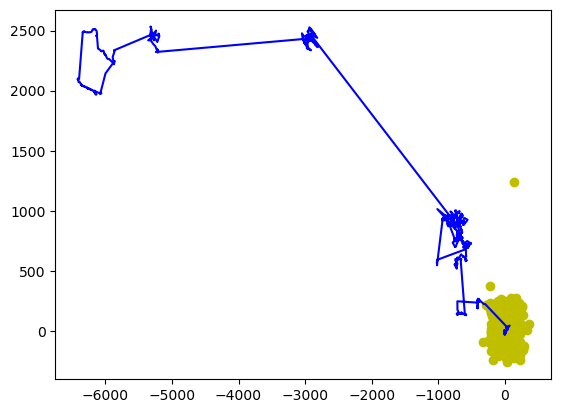

In [50]:
plt.plot(SLAM_T[0, -1], SLAM_T[1, -1], c='b')
plt.scatter(world_coordinates[0], world_coordinates[1], c='y')

In [26]:
world_coordinates[0]

array([ 5.00803576e+01,  1.20562985e+00,  4.34038017e+00,  1.27221050e+00,
        6.39358016e-01, -3.12005675e+00, -1.70545520e-01, -3.87724405e-02,
       -8.69961835e-01,  1.28037399e+00, -2.77403059e+00,  4.97552677e-02,
        8.71898104e+00,  1.38889313e+00,  4.57196898e+00,  1.64092016e-02,
        4.83840964e-01,  6.05818021e-01, -1.37559737e-01,  1.50316103e-01,
        1.05654134e+00, -4.18745806e+00, -7.31554013e-01, -7.63585883e-01,
       -3.32451501e+00, -1.61293117e+00,  8.39260331e-01,  1.26792612e+00,
       -2.21295099e+00, -1.48382521e-01,  8.72702113e+00,  6.90685206e-01,
       -9.90417147e-01,  3.86710179e-02,  2.31906998e-02, -1.14858277e+00,
        1.71980029e+00, -6.63626848e-01, -1.61625670e-01, -1.07378072e+01,
       -6.88403679e-01,  1.46745708e+00,  8.76148596e+00, -2.58030759e-01,
       -1.89352292e-01, -1.54488248e-02,  6.43611038e+00, -2.32716876e+00,
        3.94109909e-01, -2.07029005e+00, -1.11527985e-01,  1.54231664e-01,
        1.09599073e-02, -

In [55]:
world_coordinates[0]

array([ 5.00803576e+01,  1.20562985e+00,  4.34038017e+00,  1.27221050e+00,
        6.39358016e-01, -3.12005675e+00, -1.70545520e-01, -3.87724405e-02,
       -8.69961835e-01,  1.28037399e+00, -2.77403059e+00,  4.97552677e-02,
        8.71898104e+00,  1.38889313e+00,  4.57196898e+00,  1.64092016e-02,
        4.83840964e-01,  6.05818021e-01, -1.37559737e-01,  1.50316103e-01,
        1.05654134e+00, -4.18745806e+00, -7.31554013e-01, -7.63585883e-01,
       -3.32451501e+00, -1.61293117e+00,  8.39260331e-01,  1.26792612e+00,
       -2.21295099e+00, -1.48382521e-01,  8.72702113e+00,  6.90685206e-01,
       -9.90417147e-01,  3.86710179e-02,  2.31906998e-02, -1.14858277e+00,
        1.71980029e+00, -6.63626848e-01, -1.61625670e-01, -1.07378072e+01,
       -6.88403679e-01,  1.46745708e+00,  8.76148596e+00, -2.58030759e-01,
       -1.89352292e-01, -1.54488248e-02,  6.43611038e+00, -2.32716876e+00,
        3.94109909e-01, -2.07029005e+00, -1.11527985e-01,  1.54231664e-01,
        1.09599073e-02, -

In [44]:
# old
twist = np.vstack([linear_velocity, angular_velocity])
for timestamp in tqdm(range(1, t.shape[1])):
  # pose = twist2pose((t[0, timestamp]-t[0, timestamp-1])*
  #             axangle2twist(twist[:, timestamp-1]))
  
  pose = twist2pose((tau[timestamp-1] * axangle2twist(twist[:,timestamp])))

  SLAM_T[..., timestamp] = np.matmul(SLAM_T[..., timestamp-1], pose)
  robot_pos_pred = SLAM_T[:3, -1, timestamp]
  robot_ori_pred = transforms3d.euler.mat2euler(SLAM_T[:3, :3, timestamp], 'sxyz')


  visible_features_positions = np.where(np.all(features[..., timestamp]!=hidden_features, 0))[0]
  seen_features_positions = np.where(np.all(mu!=empty_features, 0))[0]
  seen_features_again_positions = np.intersect1d(visible_features_positions, seen_features_positions)
  new_features_positions = np.setdiff1d(visible_features_positions, seen_features_positions)
  
  seen_features_again = features[:, seen_features_again_positions, timestamp]
  seen_features_again_flatten_shape = seen_features_again.flatten('F').shape[0] # 4Nt
  seen_features_again_positions_shape = seen_features_again_positions.shape[0] # Nt
  new_features = features[:, new_features_positions, timestamp]
  
  mu[:, new_features_positions] = pixel_to_world(new_features, K, b, imu_T_cam, T[..., timestamp])
  
  visible_landmarks = mu[:3].flatten('F') # 3M
  
  SLAM_mu = np.concatenate([visible_landmarks, robot_pos_pred, robot_ori_pred]) # 3M+6

  z_tilda = predict_z(imu_T_cam, mu[:, seen_features_again_positions], Ks, SLAM_T[..., timestamp])

  H = np.zeros([seen_features_again_flatten_shape, visible_landmarks.shape[0]])  # 4Nt x 3M
  h1 = projectionJacobian(np.linalg.inv(imu_T_cam).dot(np.linalg.inv(T[..., timestamp]).dot(mu[:, seen_features_again_positions])).T)
  h2 = np.linalg.inv(imu_T_cam).dot(np.linalg.inv(T[..., timestamp]).dot(P.T))
  h = np.einsum('aij,jk->aik',h1,h2) 
  h = np.einsum('ij,ajl->ail',Ks,h)

  for i in range(seen_features_again_positions.shape[0]):
    H[i*4: i*4+4, i*3:i*3+3] = h[i, :, :]


  pos_temp = np.linalg.inv(SLAM_T[..., timestamp]).dot(mu[:, seen_features_again_positions])
  h3 = np.einsum('ij,jkl->ikl', np.linalg.inv(imu_T_cam), dot(pos_temp)) # 4 x 6 x Nt
  h4 = np.einsum('ijk,jli->jli', h1, h3) # 4 x 6 x Nt
  h5 = np.einsum('ij,jlk->ilk', -Ks, h4) # 4 x 6 x Nt
  h5_ = np.reshape(h5, [h5.shape[0]*h5.shape[2], h5.shape[1]]) # 4Nt x 6

  SLAM_combined_jacobian = np.hstack([H, h5_])

  IV = V*np.eye(seen_features_again_flatten_shape)

  k_1 = SLAM_sigma.dot(SLAM_combined_jacobian.T)
  k_2 = SLAM_combined_jacobian.dot(k_1) + IV
  kalman_gain = k_1.dot(np.linalg.inv(k_2))

  del_z = seen_features_again - z_tilda
  del_z = del_z.flatten('F') #  4Nt
  K_del_z = kalman_gain.dot(del_z)
  visible_landmarks += K_del_z[:3*features.shape[1]]
  new_mu = np.reshape(visible_landmarks, [3, features.shape[1]])
  mu = np.vstack([new_mu, np.ones([1, features.shape[1]])])

  new_pose = axangle2twist(K_del_z)
  SLAM_T[..., timestamp] = SLAM_T[..., timestamp].dot(linalg.expm(new_pose))

  SLAM_sigma = (np.eye(3*features.shape[1]+6) -
                kalman_gain.dot(SLAM_combined_jacobian)).dot(SLAM_sigma)

 55%|█████▍    | 1659/3025 [00:34<00:28, 48.03it/s]


KeyboardInterrupt: 